In [1]:
from sklearn.datasets import load_iris, load_wine, load_breast_cancer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Carichiamo il dataset e mettiamo i dati in un DataFrame

In [2]:
iris = load_iris()
scaler = StandardScaler()
scaled_data = scaler.fit_transform(iris.data)
data = pd.DataFrame(scaled_data)
data

,0,1,2,3
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444
...,...,...,...,...
145,1.038005,-0.131979,0.819596,1.448832
146,0.553333,-1.282963,0.705921,0.922303
147,0.795669,-0.131979,0.819596,1.053935
148,0.432165,0.788808,0.933271,1.448832


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000013FD950A5C8>,
      dtype=object)

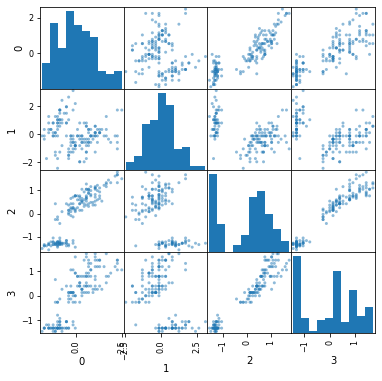

In [3]:
pd.plotting.scatter_matrix(data, figsize = (6,6))

Dallo scatter plot possiamo vedere come tra nessun coppia di features è possibile distinguere tre cluster sulla base della loro densità. Probabilmente DBSCAN non porterà a nessun buon risultato con questo dataset.

Prendiamo ora i label e mettiamoli in un DataFrame. Contiamo anche il numero di occorrenze per ogni classe

In [4]:
target = pd.DataFrame(iris.target)
target

,0
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


In [5]:
target[0].value_counts()

2    50
1    50
0    50
Name: 0, dtype: int64

Usiamo PCA per rapprensetare in 2D il nostro dataset. Usiamo le label in target appena trovate per avere un riferimento per valutare visivamente la bontà dei cluster trovati con le varie tecniche.

In [6]:
pca = PCA(n_components=2).fit(data)
pca_2d = pca.transform(data)
pca_2d = pd.DataFrame(pca_2d)
pca_2d

,0,1
0,-2.264703,0.480027
1,-2.080961,-0.674134
2,-2.364229,-0.341908
3,-2.299384,-0.597395
4,-2.389842,0.646835
...,...,...
145,1.870503,0.386966
146,1.564580,-0.896687
147,1.521170,0.269069
148,1.372788,1.011254


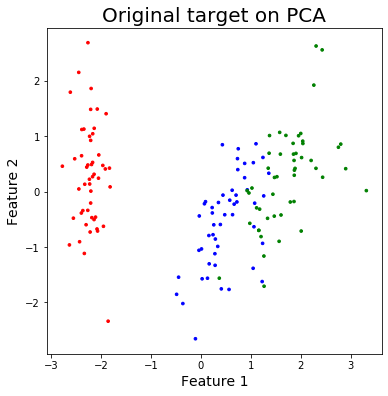

In [7]:
colors = ['red','blue','green']
plt.figure(figsize=(6, 6))
plt.scatter(pca_2d[0], pca_2d[1], c=target[0], cmap=matplotlib.colors.ListedColormap(colors), s=7)
plt.title("Original target on PCA",fontsize=20)
plt.xlabel('Feature 1',fontsize=14)
plt.ylabel('Feature 2',fontsize=14)
plt.show()

Proviamo con DBSCAN, usando i valori di default di sklearn.

In [8]:
dbscan = DBSCAN()
dbscan.fit(data)

DBSCAN()

In [9]:
df=pd.DataFrame()
df['DBSCAN_labels'] = dbscan.labels_
df['DBSCAN_labels'].value_counts()

 1    71
 0    45
-1    34
Name: DBSCAN_labels, dtype: int64

Abbiamo trovato solo due classi e gli outlier

In [10]:
pd.unique(df['DBSCAN_labels'])

array([ 0, -1,  1], dtype=int64)

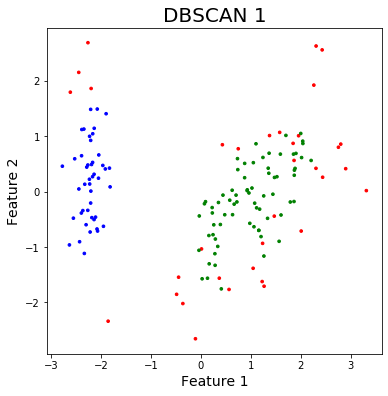

In [11]:
def visualize_2d(data, labels, colors, title):
    plt.figure(figsize=(6, 6))
    plt.scatter(data[0],data[1],c=labels,cmap=matplotlib.colors.ListedColormap(colors),s=7)
    plt.title(title,fontsize=20)
    plt.xlabel('Feature 1',fontsize=14)
    plt.ylabel('Feature 2',fontsize=14)
    plt.show()
    
colors = ["red", "blue", "green"]
visualize_2d(pca_2d, df['DBSCAN_labels'], colors, "DBSCAN 1")

DBSCAN con valori di default è riuscito comunque a trovare dei cluster, ma l'effetto ottenuto non è quello desiderato. Ha correttametne individuato due cluster, ma il cluster verde con i gli outlier in rosso che lo contornano andrebbe scomposto in due ulteriori cluster. Proviamo a impostare i parametri di DBSCAN avvalendosi dell'euristica di supporto.

In [12]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=4)
nbrs = neigh.fit(iris.data)
distances, indices = nbrs.kneighbors(iris.data)

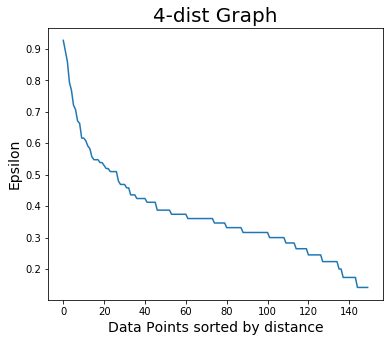

In [13]:
# Plotting K-distance Graph
distances = distances[:,3]
distances = np.sort(distances, axis=0)[::-1]

plt.figure(figsize=(6,5))
plt.plot(distances)
plt.title('4-dist Graph',fontsize=20)
plt.xlabel('Data Points sorted by distance',fontsize=14)
plt.ylabel('Epsilon',fontsize=14)
plt.show()

All'incirca poco prima di 20 abbiamo la massima curvatura della funzione 4-dist. Sciegliamo epsilon=0.55 e di conseguenza MinPts=4.

In [33]:
dbscan_opt=DBSCAN(eps=0.55, min_samples=4)
dbscan_opt.fit(data)

DBSCAN(eps=0.55, min_samples=4)

In [34]:
df['DBSCAN_opt_labels'] = dbscan_opt.labels_
df['DBSCAN_opt_labels'].value_counts()

 1    77
 0    45
-1    28
Name: DBSCAN_opt_labels, dtype: int64

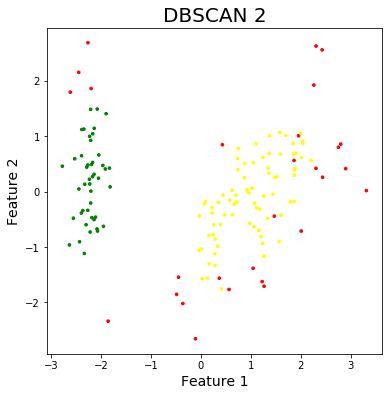

In [35]:
colors = ["red", "blue", "green", "yellow"]
visualize_2d(pca_2d, df['DBSCAN_opt_labels'], colors, "DBSCAN 2")

Abbiamo ridotto il numero di outliers trovati ma l'algoritmo come aspettato non è riuscito a scomporre correttamente il cluster in giallo in due. Inoltre ha identificato un ulteriore cluster di 3 punti in verde nella zona in alto a sx.

Proviamo quindi con k-means.

In [17]:
from sklearn.cluster import KMeans
k_means=KMeans(n_clusters=3,random_state=42)
k_means.fit(data)

KMeans(n_clusters=3, random_state=42)

In [18]:
df['KMeans_labels']=k_means.labels_
df['KMeans_labels'].value_counts()

2    53
0    50
1    47
Name: KMeans_labels, dtype: int64

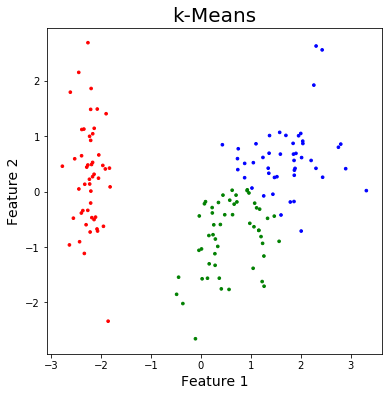

In [19]:
colors = ["red", "blue", "green"]
visualize_2d(pca_2d, df['KMeans_labels'], colors, "k-Means")

K-Means ha indentificato correttamente i cluster.

In [20]:
df

,DBSCAN_labels,DBSCAN_opt_labels,KMeans_labels
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
145,1,2,1
146,1,2,2
147,1,2,1
148,-1,2,1
